<a href="https://colab.research.google.com/github/laura314159265/poly/blob/main/PR%C3%80CTICA_GUIADA/P1_EULER_IMPLICIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Volem trobar els valors de les temperatures de la següent forma:

$\vec{T_i}=M^{-1}(\vec{T_{i-1}}+\vec{\Delta t})$


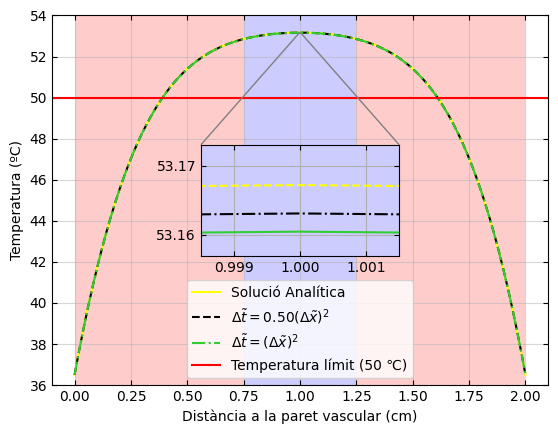

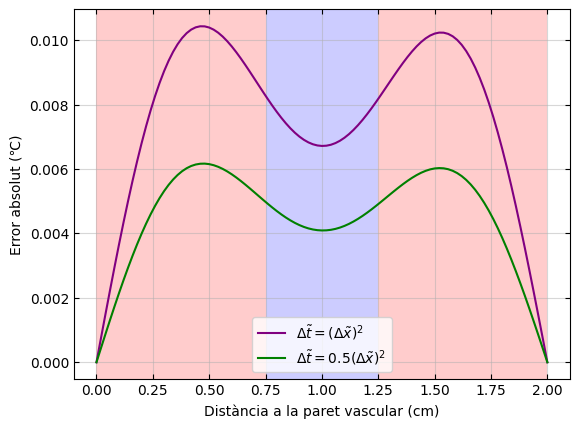

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset # Per fer el Zoom

# CÀLCULS PREVIS
    # Dades de l'enunciat
C_v= 3686
rho= 1081
kappa= 0.56
sigma= 0.472
volts= 40
    # Amb aquests, calculem la difusivitat, que farem servir per a la normalització
alpha= kappa/(C_v*rho)

    # Imposem la nostra normalització
N= 101
x_0= 0.02 # Longitud de referència, triada per tal de normalitzar x_f,
x_f= 0.02/x_0 # Longitud final normalitzada

t_i= 0 #Temps inicial
t_0= x_0**2/alpha #Temps de referència, surt de la normalització de l'equació diferencial
t_f= 0.025 # Temps final ja normalitzat, ho diu l'enunciat

P_ext= volts**2*sigma/(2*(x_0)**2) # Calculada per anàlisi dimensional a partir de dades proporcionades, el factor 2 dividint és perquè s'ha d'agafar el voltatge efectiu
T_0= P_ext/(C_v*rho)*t_0 # Temperatura de referència, en kelvin
T_init= 309.65/T_0 # Temperatura inicial 36.5℃ normalitzada i en kelvins

    # Definim els dos casos a considerar de discretitzacions
dx= x_f/(N-1) # Valor de les particions espacials donat un nombre N de nodes espaials
dt_1= dx**2
dt_2= 0.5*dx**2




def gauss_seidel(A, b, x0, err):
    #Resol una equació lineal algebraica de l'estil Ax=b on A matriu b i x vectors
    #el vector x és el de les incògnites

    n = len(A[0])
    x = x0.copy() # Copiem x0 per evitar que x0 i x apuntin al mateix objecte i evitar que quan modifiquis un es modifiqui també l'altre

    while True:
        x_ant = x.copy()
        for i in range(n):
            sum1 = np.dot(A[i, :i], x[:i]) # Part del sumatori que utilitza els x_i+1 (nous ja calculats)
            sum2 = np.dot(A[i, i+1:], x_ant[i+1:]) # Part del sumatori que utilitza els x_1 ("anteriors")

            # Ens assegurem que la diagonal de A to tingui 0 (per evitar dividir per 0 en l'esquema d'iteració)
            if A[i, i] == 0:
                print ("Algun element de la diagonal de A és 0")
                break
            x[i] = (b[i] - sum1 - sum2) / A[i, i]

        # Mirem la convergència tal com hem vist a teoria
        if np.abs(max(x - x_ant)) < err: #on err és l'error màxim que tolerem
            return np.array(x)




# Creem una funció aplicable a qualsevol temperatura inicial (sempre que sigui la mateixa temperatura que als contorns),
def Euler_implicit (T_i, t_f, dx, dt): # Li has de passar les variables (escalars) normalizades
    T_i_vect=np.ones(N)*T_i
    i= 1
    # Creem la matriu M
    gamma= dt/(dx**2)
    col1= [0]*(N)
    fila1= [0]*(N)
    col1[0] = fila1[0] = 1 + 2*gamma
    col1[1] = fila1[1] = -gamma
    matriu = toeplitz(col1, fila1) # Crea una matriu tridiagonal amb 1-2gamma a la diagonal princial i -gamma a les diagonals de sobre i de sota

    #IMPOSEM LES CONDICIONS DE CONTORN
    matriu[0,:]  = 0 #això vol dir que tots els elements (:) de la primera fila (la fila 0, corresponent al temps inicial t=0) valen 0
    matriu[0,0]  = 1 #i després de fer que tots els elements valguin 0 fas que el primer (el de la primera fila i la primera columna
                          #és a dir, el primer de la diagonal) valgui 1, de forma que quan multipliques la matriu per T_inic et continua
                          #quedant T_inic
    matriu[-1,:] = 0 #el mateix que abans, fas que tots els elements de la última fila siguin 0 excepte el de l'última columna, és a dir,
                          #l'últim de la diagonal, el qual val 1
    matriu[-1,-1]= 1

    t = int(t_f/dt)
    for i in range(t): #com la nostra equació és de la forma Ax=b, on A=inv(M) i x=\vec{T_i}, anem a trobar b=\vec{T_{i-1}+∆t}
      # I apliquem això per trobar T_i_vect
      b = T_i_vect + np.ones(N)*dt
      b[0]  = T_i
      b[-1] = T_i

      T_i_vect = gauss_seidel(matriu,b,T_i_vect,1e-8)
    # print("amb un dt=",dt,", calen",i,"iteracions per arribar immediatament abans del temps normalitzat", t_f)
    return T_i_vect

# Apliquem la funció que hem creat als nostres dos casos de discretitzacions, desfem la normalització i passem a ℃
T1 = Euler_implicit(T_init, t_f, dx, dt_1)* T_0 - 273.15
T2 = Euler_implicit(T_init, t_f, dx, dt_2)* T_0 - 273.15



# PLOTS
x = np.linspace(0, 2, 101) # Eix de les x en cm

# Solució analítica en ºC prèviament calculada
T_real_analitica = [36.5, 37.66969108, 38.77435843, 39.81640155, 40.79821064, 41.72216161,
 42.59061136, 43.40589333, 44.17031304, 44.88614393, 45.55562325, 46.18094826,
 46.76427258, 47.30770281, 47.81329543, 48.28305392, 48.71892617, 49.12280218,
 49.49651205, 49.84182427, 50.16044422, 50.45401308, 50.72410691, 50.97223607,
 51.19984485, 51.40831139, 51.59894779, 51.77300053, 51.93165095, 52.07601607,
 52.20714947, 52.32604233, 52.43362469, 52.53076667, 52.61827989, 52.69691893,
 52.76738279, 52.83031642, 52.88631225, 52.93591169, 52.97960659, 53.01784069,
 53.05101097, 53.07946891, 53.10352169, 53.12343327, 53.13942529, 53.15167798,
 53.16033077, 53.16548287, 53.16719365, 53.16548287, 53.16033077, 53.15167798,
 53.13942529, 53.12343327, 53.10352169, 53.07946891, 53.05101097, 53.01784069,
 52.97960659, 52.93591169, 52.88631225, 52.83031642, 52.76738279, 52.69691893,
 52.61827989, 52.53076667, 52.43362469, 52.32604233, 52.20714947, 52.07601607,
 51.93165095, 51.77300053, 51.59894779, 51.40831139, 51.19984485, 50.97223607,
 50.72410691, 50.45401308, 50.16044422, 49.84182427, 49.49651205, 49.12280218,
 48.71892617, 48.28305392, 47.81329543, 47.30770281, 46.76427258, 46.18094826,
 45.55562325, 44.88614393, 44.17031304, 43.40589333, 42.59061136, 41.72216161,
 40.79821064, 39.81640155, 38.77435843, 37.66969108, 36.5]




fig, ax = plt.subplots()
# Canviem el color del fons per representar les parets vasculars
plt.axvspan(0, 0.75,  facecolor='red',  alpha=0.2)
plt.axvspan(0.75, 1.25, facecolor='blue',  alpha=0.2)
plt.axvspan(1.25, 2,  facecolor='red',  alpha=0.2)


# REPRESENTACIÓ DELS RESULTATS
plt.plot(x, T_real_analitica, color="yellow", label="Solució Analítica")
plt.plot(x, T2, color="k", label=r"$\Delta \tilde{t}= 0.50(\Delta \tilde{x})^2$", linestyle="--")
plt.plot(x, T1, color="limegreen", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$", linestyle="-.")
ax.axhline(y=50, color='red',label="Temperatura límit (50 ℃)")

plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Temperatura (ºC)")
ax.tick_params(direction='in', top=True, right=True)
plt.xlim(-0.1,2.1)
plt.ylim(36, 54)
plt.grid("equal", alpha=0.5)
plt.legend()

# ZOOM per poder visualitzar les diferències
axins1 = inset_axes(
    ax,
    width="40%",
    height="30%",
    loc='center'
)
axins1.set_facecolor("#CCCCFF")

axins1.plot(x, T1, color="limegreen")
axins1.plot(x, T2, color="k", linestyle="-.")
axins1.plot(x, T_real_analitica, "--", color="yellow")

axins1.set_xlim(0.9985, 1.0015)
axins1.set_ylim(53.157, 53.173)
axins1.grid()
axins1.set_xticks([0.999, 1, 1.001])
axins1.set_yticks([53.16, 53.17])

axins1.ticklabel_format(style='plain', axis='y')
axins1.yaxis.get_major_formatter().set_useOffset(False)
axins1.tick_params(direction='in', top=True, right=True, bottom=True, labelbottom=True)
mark_inset(ax, axins1, loc1=1, loc2=2, fc="none", ec="0.5")
plt.show()

# REPRESENTACIÓ DELS ERRORS ABSOLUTS
plt.figure()

# Canviem el color del fons per representar les parets vasculars
plt.axvspan(0, 0.75,  facecolor='red',  alpha=0.2)
plt.axvspan(0.75, 1.25, facecolor='blue',  alpha=0.2)
plt.axvspan(1.25, 2,  facecolor='red',  alpha=0.2)
plt.xlim(-0.1,2.1)

plt.plot(x, abs(T1-T_real_analitica), color="purple", label=r"$\Delta \tilde{t}= (\Delta \tilde{x})^2$")
plt.plot(x, abs(T2-T_real_analitica), color="green", label=r"$\Delta \tilde{t}= 0.5(\Delta \tilde{x})^2$")

plt.xlabel("Distància a la paret vascular (cm)")
plt.ylabel("Error absolut (℃)")
plt.tick_params(direction="in", top=True, right=True)
plt.grid("equal", alpha=0.5)
plt.legend()
plt.show()
